## ECG Beat & Noise Analysis and Visualization
# 
# This notebook loads data for a specific `caseid` from `vitaldb`, then runs the custom filter (`ecg_beat_noise_detector`) that has been manually added to the local `pyvital` package.
# 
# Finally, it visualizes the analyzed beat classifications and noise intervals along with the original ECG waveform.


In [6]:
# Import all necessary libraries
import vitaldb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import os
%matplotlib inline


In [7]:
# === Set Parameters for Analysis and Visualization ===

# The patient case ID to analyze
CASE_ID = 1

# The name of the custom filter added to the local pyvital package
# (This should match the name of the .py file, e.g., ecg_beat_noise_detector.py)
FILTER_NAME = 'ecg_beat_noise_detector'

# The name of the output track created by the filter (as defined in its cfg)
OUTPUT_TRACK_NAME = 'BEAT_NOISE'

# The name of the original raw ECG track
ECG_TRACK_NAME = 'ECG_II'

# Settings for the plotting window (in seconds)
START_SECOND = 150  # Start time
DURATION = 20       # Length of the window

# Sampling rate in Hz
SRATE = 100

print("Parameters set successfully.")

Parameters set successfully.


In [11]:
# === Load VitalFile and Run the Filter ===

# 1. Import the custom filter module directly from the pyvital package
from pyvital.filters import ecg_beat_noise_detector

print(f"Loading data for Case ID: {CASE_ID}...")
# Create a VitalFile object. The data will be downloaded automatically if not found locally.
vf = vitaldb.VitalFile(CASE_ID)

print(f"Running filter: '{FILTER_NAME}'...")
# Call run_filter, passing the actual .run function and .cfg object from the imported module.
# This process adds the 'BEAT_NOISE' track to the vf object.
vf.run_filter(ecg_beat_noise_detector.run, ecg_beat_noise_detector.cfg)

print("Analysis complete.")

Loading data for Case ID: 1...
Running filter: 'ecg_beat_noise_detector'...
Analysis complete.


In [12]:
# === Prepare Data for Plotting ===

print("Preparing data for plotting...")

# 1. Extract the original ECG waveform data
ecg_data = vf.to_numpy([ECG_TRACK_NAME], 1/SRATE)

# 2. Extract the analysis results (annotations)
# Load the records, which are stored with absolute timestamps
annotations_abs = vf.trks[OUTPUT_TRACK_NAME].recs
file_start_time = vf.dtstart

# 3. Convert absolute annotation times to relative times (from the start of the file)
annotations = []
for ann in annotations_abs:
    relative_dt = ann['dt'] - file_start_time
    annotations.append({'dt': relative_dt, 'val': ann['val']})

# 4. Parse the annotations into separate lists for beats and noise intervals
beat_annotations = []
noise_intervals = []
noise_starts = {}

for ann in annotations:
    val = ann['val']
    if val.startswith('Noise_start'):
        noise_id = val.replace('Noise_start', '')
        noise_starts[noise_id] = ann['dt']
    elif val.startswith('Noise_end'):
        noise_id = val.replace('Noise_end', '')
        if noise_id in noise_starts:
            start_dt = noise_starts.pop(noise_id)
            end_dt = ann['dt']
            noise_intervals.append((start_dt, end_dt))
    else:
        beat_annotations.append(ann)

print(f"Data preparation complete: {len(beat_annotations)} beats and {len(noise_intervals)} noise intervals found.")



Preparing data for plotting...
Data preparation complete: 18599 beats and 1168 noise intervals found.


Visualizing results...


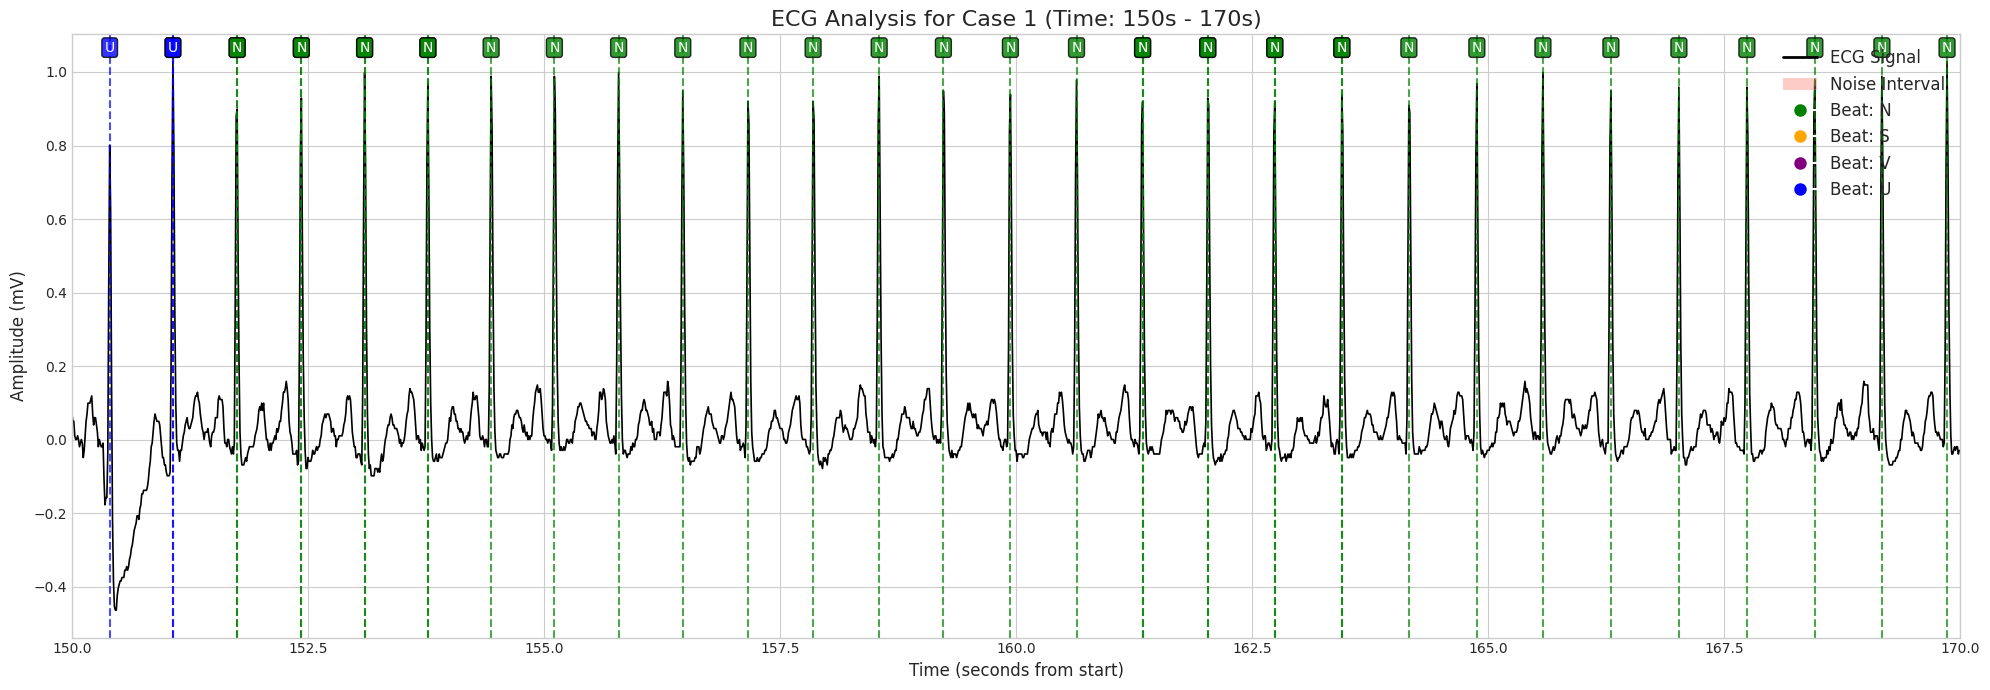

In [13]:
# === Visualize the Final Results ===

print("Visualizing results...")

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(20, 7))

# 1. Plot the ECG signal for the specified window
start_index = int(START_SECOND * SRATE)
end_index = int((START_SECOND + DURATION) * SRATE)
ecg_segment = ecg_data[start_index:end_index]
time_segment = np.arange(len(ecg_segment)) / SRATE + START_SECOND

plt.plot(time_segment, ecg_segment, label='ECG Signal', color='black', linewidth=1.2)

# 2. Shade the noise intervals in the background
for start, end in noise_intervals:
    if end > START_SECOND and start < (START_SECOND + DURATION):
        plt.axvspan(
            max(start, START_SECOND), 
            min(end, START_SECOND + DURATION), 
            color='salmon', alpha=0.4, zorder=0
        )

# 3. Plot the beat classification results
beat_colors = {'N': 'green', 'S': 'orange', 'V': 'purple', 'U': 'blue'}
for ann in beat_annotations:
    if START_SECOND <= ann['dt'] < (START_SECOND + DURATION):
        color = beat_colors.get(ann['val'], 'grey')
        plt.axvline(x=ann['dt'], color=color, linestyle='--', alpha=0.7)
        plt.text(
            ann['dt'], plt.ylim()[1] * 0.95, ann['val'], 
            rotation=0, va='bottom', ha='center', color='white',
            bbox=dict(facecolor=color, alpha=0.8, boxstyle='round,pad=0.2')
        )

# 4. Create a custom legend and configure the plot
legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='ECG Signal'),
    Patch(facecolor='salmon', alpha=0.4, label='Noise Interval')
]
for label, color in beat_colors.items():
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f'Beat: {label}',
                                  markerfacecolor=color, markersize=10))

plt.legend(handles=legend_elements, loc='upper right', fontsize=12)
plt.title(f'ECG Analysis for Case {CASE_ID} (Time: {START_SECOND}s - {START_SECOND + DURATION}s)', fontsize=16)
plt.xlabel('Time (seconds from start)', fontsize=12)
plt.ylabel('Amplitude (mV)', fontsize=12)
plt.xlim(START_SECOND, START_SECOND + DURATION)
plt.tight_layout()
plt.show()
